In [90]:
from typing import Annotated, Literal, TypedDict
from langchain_chroma import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from typing import Optional, Type
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import BaseTool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.callbacks.manager import CallbackManagerForToolRun
from langchain_core.output_parsers import StrOutputParser

In [91]:
model_name = 'dunzhang/stella_en_1.5B_v5'
model_kwargs = {'device': 'cuda', "trust_remote_code": True}

embedding_model = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
)

vector_store = Chroma(
    collection_name="faq",
    persist_directory="../db",
    embedding_function=embedding_model,
    collection_metadata={"hnsw:space": "cosine"}
)

retriever = vector_store.as_retriever(
    search_kwargs={'k': 2}
)

ImportError: This modeling file requires the following packages that were not found in your environment: flash_attn. Run `pip install flash_attn`

In [72]:
class AnswerAboutSelfInput(BaseModel):
    query: str = Field(description="query about yourself or user greeting")

class AnswerAboutSelf(BaseTool):
    name = "answer_about_self"
    description = "Use this tool if the user query is a question about the chatbot, or if it is a greeting or a farewell.\nThe action input must be the user query unedited."
    args_schema: Type[BaseModel] = AnswerAboutSelfInput
    return_direct = True

    def _run(self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None) -> str:
        system_prompt = (
            "Your name is Hoku. You are an assistant for answering questions about UH Manoa.\n"
            "You were initially created during the Hawaii Annual Code Challenge by team DarkMode.\n"
            "You are currently under development.\n"
            "Only respond with information given here.\n"
            "Answer concisely do not add any additional information.\n"
            "Reiterate the query then give a concise answer."
        )

        qa_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_prompt),
                ("human", "{query}"),
            ]
        )

        chain = qa_prompt | self.metadata['llm'] | StrOutputParser()
        return chain.invoke({"query": query})

In [ ]:
@tool
def search(query: str) -> str:
    """Use this tool to surf the web about weather updates"""

    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 89 degrees and sunny."

In [92]:
llm = ChatOpenAI(
    api_key="ollama",
    model="mistral-nemo:latest",
    base_url="http://localhost:11434/v1",
    temperature=0,
)

tools = [AnswerAboutSelf(metadata={'llm': llm})]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

In [93]:
llm.invoke("hello")

KeyboardInterrupt: 

In [ ]:
from langgraph.prebuilt import create_react_agent

In [74]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]

    if last_message.tool_calls:
        return "tools"

    return "__end__"


def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

In [75]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [76]:
def should_return_direct(state: MessagesState) -> Literal["agent", "__end__"]:
    messages = state['messages']
    last_message = messages[-1]
    return "__end__"

In [77]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")


workflow.add_conditional_edges(
    "agent",
    should_continue,
)

workflow.add_edge("tools", 'agent')
# workflow.add_conditional_edges("tools")
checkpointer = MemorySaver()

app = workflow.compile(checkpointer=checkpointer)

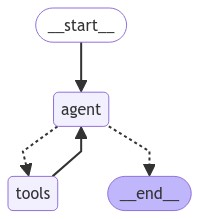

In [78]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [84]:
inputs = {"messages": [("user", "what can you help with?")]}
print_stream(app.stream(inputs, config={"configurable": {"thread_id": 42}}, stream_mode="values"))

================================ Human Message =================================

what can you help with?
================================== Ai Message ==================================
Tool Calls:
  answer_about_self (call_0y041qqw)
 Call ID: call_0y041qqw
  Args:
    query: what can you help with?
================================= Tool Message =================================
Name: answer_about_self

Query: What can you help with?
Answer: I can assist with answering questions about UH Manoa.
================================== Ai Message ==================================

 I can provide information and answer questions related to the University of Hawaii at Manoa. For example, I can tell you about its history, campus, academic programs, or student life. Is there something specific you would like to know?


In [33]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="who created you?")]},
    config={"configurable": {"thread_id": 42}}
)

print(final_state["messages"][-1].content)

Do you have any other questions about my creation or anything else?
